In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate

rcParams['font.size'] = 20
rcParams['lines.linewidth'] = 2.5

from ComptonSpec_classic import Trajectory, Spectrum

In [37]:
print(rcParams.keys())

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

/usr/lib/python3.8/_collections_abc.py:705: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  return '{0.__class__.__name__}({0._mapping!r})'.format(self)


In [35]:
#Create an instance of Trajectory class and calculate a trajectory

u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

# Laser pulse parameters
tau = 2 * 2 * np.pi  # Pulse duration
a0 = 1               # Pulse amplitude
mode = 'gauss'       # Temporal envelope
polarization = 'circular'

def envelope(x, mode='gauss'):
    if mode == 'rectangle':
        idx = (x >= -tau/2) & (x <= tau/2)
        g = np.zeros_like(x)
        g[idx] = 1
    elif mode == 'super gauss':
        g = np.exp(-(x/tau)**60)
    elif mode == 'gauss':
        g = np.exp(-x**2/tau**2)
    return g

def phase(x):
    return x

envelope = np.vectorize(envelope)
phase = np.vectorize(phase)

def calc_A(x):
    ph = phase(x)
    if polarization == 'circular':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.sin(ph)])
    elif polarization == 'linear':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.zeros_like(ph)])

eta_b = 4.4*tau
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta)
u, r = traj.calc_u_x(A, eta)

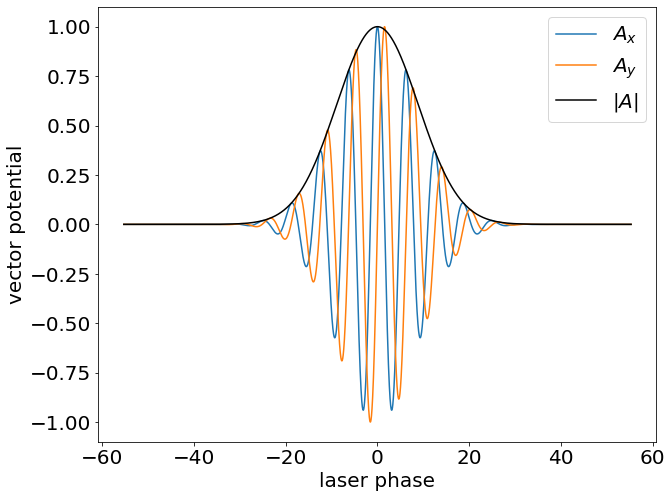

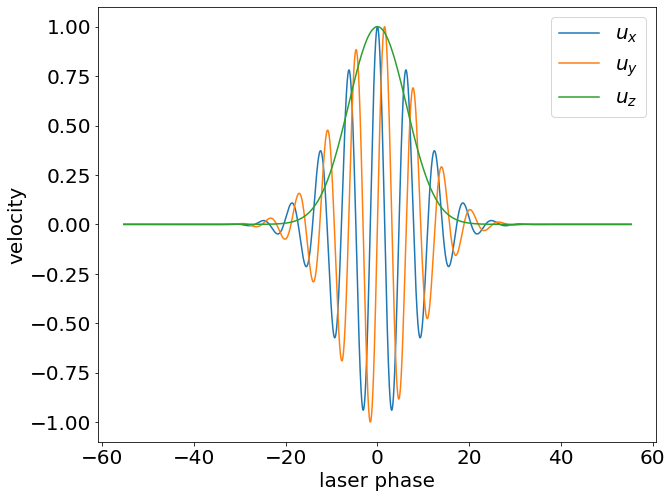

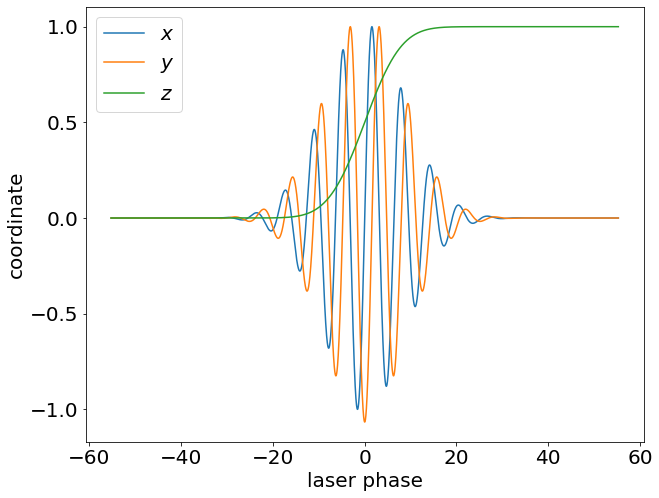

In [36]:
# Plot electron velocity and coordinate

A_mod = np.sqrt(A[0]**2 + A[1]**2)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, A[0]/np.max(A[0]), label='$A_x$')
plt.plot(eta, A[1]/np.max(A[1]), label='$A_y$')
plt.plot(eta, A_mod/np.max(A_mod), label='$|A|$', color='black')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('vector potential')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, u[0]/np.max(u[0]), label='$u_x$')
plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')
plt.plot(eta, u[2]/np.max(u[2]), label='$u_z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('velocity')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, r[0]/np.max(r[0]), label='$x$')
plt.plot(eta, r[1]/np.max(r[1]), label='$y$')
plt.plot(eta, r[2]/np.max(r[2]), label='$z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('coordinate')
plt.show()

In [30]:
# Create an instance of Spectrum class and calculate the emission spectrum based on trajectories
spec = Spectrum(eta, u, r)

theta = np.pi
phi = 0
I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)

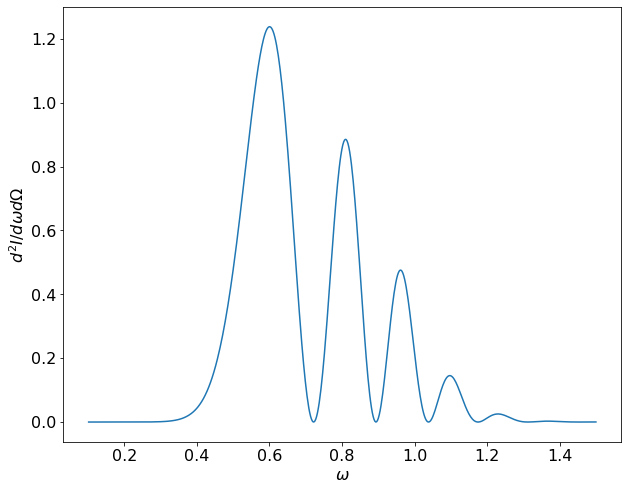

In [32]:
# Plot spectrum I(w)
w0, w1 = [0.1, 1.5]
idx = (w >= w0) & (w <= w1)
w_plot, I_plot = w[idx], I[idx]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_plot, I_plot)
plt.xlabel('$\omega$')
plt.ylabel('$d^2 I / d\omega d\Omega$')
plt.show()

In [6]:
# Create a grid of theta angles and calculate spectrum on it I(theta, w)
theta_start, theta_end = np.pi/4, np.pi
n_theta = 50
theta_arr = np.linspace(theta_start, theta_end, n_theta)
# Without interpolation on the same frequncy grid and without fixed_length
I_theta_w_list, _, w_list = spec.calc_spectrum_I_theta_w(theta_arr, interpolate_w=False,
                                                        fixed_length=False)
print('Notice the difference between frequncy grids for different angles')
print(len(w_list), w_list[0][-1], w_list[-1][-1])

# Without interpolation and with fixed_length
I_theta_w_fixed, theta_fixed, w_fixed = spec.calc_spectrum_I_theta_w(theta_arr, interpolate_w=False,
                                                                     fixed_length=True)
print('Spectrum shape on different frequency grid of the same size')
print(I_theta_w_fixed.shape, theta_fixed.shape, w_fixed.shape)

# With interpolation
I_theta_w, _, w = spec.calc_spectrum_I_theta_w(theta_arr, interpolate_w=True, w_bound=[0.02,3.])
print('Spectrum shape on interpolated frequency grid', I_theta_w.shape)

Notice the difference between frequncy grids for different angles
50 314.14027580762706 314.15262011445805
Spectrum shape on different frequency grid of the same size
(50, 65535) (50, 65535) (50, 65535)
Spectrum shape on interpolated frequency grid (50, 621)


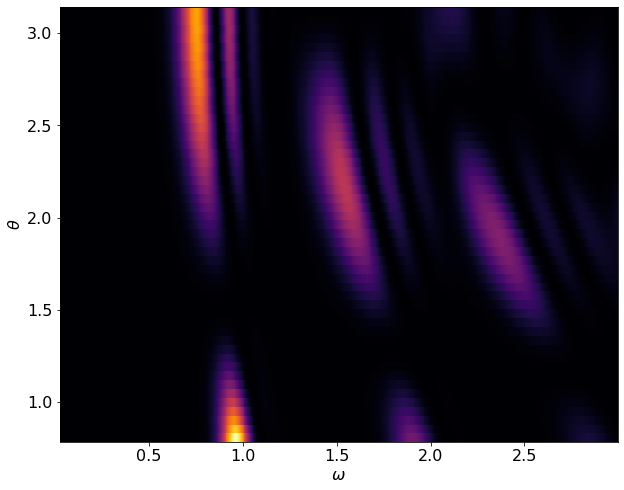

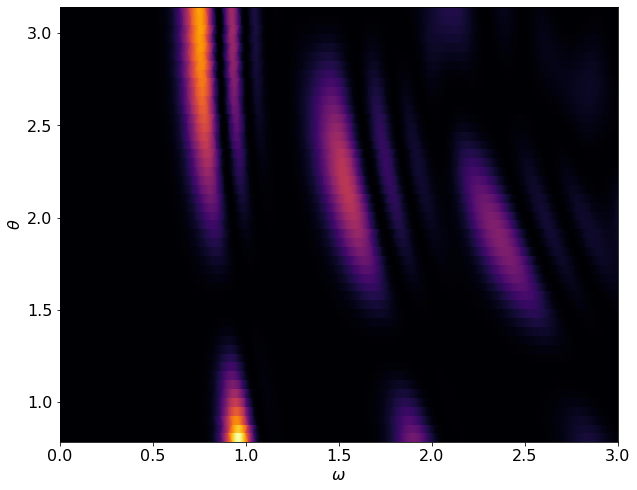

In [7]:
# Plot spectrum I(theta, w) on interpolated grid
fig, ax = plt.subplots(figsize=(10,8))
plt.pcolormesh(w, theta_arr, I_theta_w, cmap='inferno')
plt.xlabel('$\omega$')
plt.ylabel('$\\theta$')
plt.show()

# Plot spectrum I(theta, w) on different frequency grids of fixed size
fig, ax = plt.subplots(figsize=(10,8))
plt.pcolormesh(w_fixed, theta_fixed, I_theta_w_fixed, cmap='inferno')
ax.set_xlim([0,3.])
plt.xlabel('$\omega$')
plt.ylabel('$\\theta$')
plt.show()

In [8]:
# Perform Lorentz transformation to Laboratory frame of reference
gamma = 10
w0, w1 = [0., 16.]
idx = (w_fixed[-1] > w0) & (w_fixed[-1] < w1)
I_L, theta_L, w_L = Spectrum.Lorentz_transform_I_theta_w(I_theta_w_fixed[:,idx], theta_fixed[:, idx],
                                                         w_fixed[:,idx], gamma=gamma)

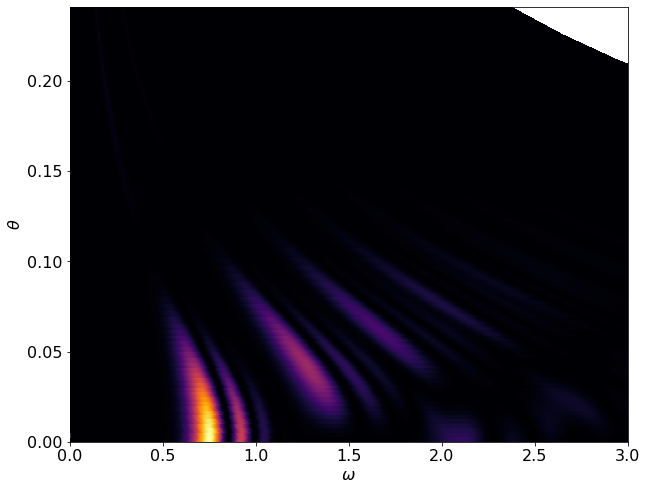

In [9]:
# Plot spectrum in Lab frame (notice that closer to theta=0 the frequency grid is more compressed)
fig, ax = plt.subplots(figsize=(10,8))
plt.pcolormesh(w_L/(2*gamma), np.pi-theta_L, I_L, cmap='inferno')
ax.set_xlim([0,3.])
plt.xlabel('$\omega$')
plt.ylabel('$\\theta$')
plt.show()

In [10]:
# If frequency grid is not the same for different directions, firstly one needs to interpolate
# spectrum on one grid
w_bound = [0.02, 3.]
I_L_interpolated, w_L_interpolated = Spectrum.interpolate_I_theta_w(I_L, w_L/(2*gamma),
                                                                    w_bound=w_bound)
theta_L_interpolated = theta_L[:,0]

# Collimate over theta_col angle and calculate the number of photons
theta_col = 0.2/gamma
I_w_L_collimated = Spectrum.collimate_I_theta_w(I_L_interpolated, theta_L_interpolated,
                                                w_L_interpolated, theta_col=theta_col)
I_w_L_collimated *= 2 * np.pi

# Calculate number of photons
w_bound = [0.5, 0.8]
N_ph_w_L_collimated = I_w_L_collimated / (2*gamma*w_L_interpolated) / 137
n_photons = Spectrum.integrate_I_w(N_ph_w_L_collimated, w_L_interpolated, w_bound)
print('Number of photons: {}'.format(n_photons))

Number of photons: 4.682195911669666e-05


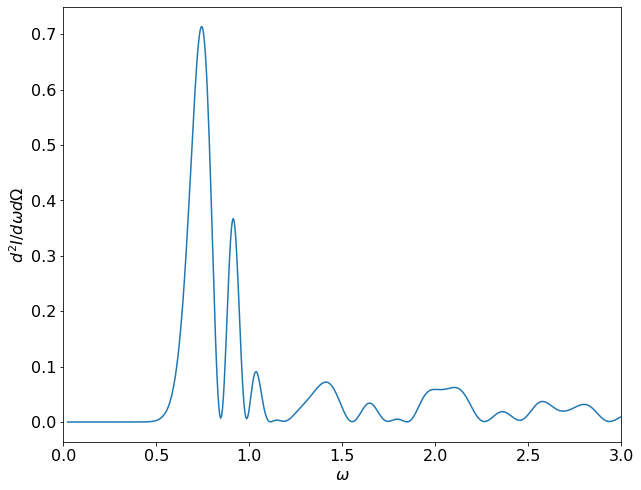

In [11]:
# Plot collimated spectra
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_L_interpolated, I_w_L_collimated)
ax.set_xlim([0,3.])
plt.xlabel('$\omega$')
plt.ylabel('$d^2 I / d\omega d\Omega$')
plt.show()

In [12]:
# Calculate spectrum over theta and phi grids
theta_start, theta_end = np.pi/4, np.pi
n_theta = 20
theta_arr = np.linspace(theta_start, theta_end, n_theta)

phi_start, phi_end = 0, 2*np.pi
n_phi = 20
phi_arr = np.linspace(phi_start, phi_end, n_phi)

I_phi_theta_w, _, _, w = spec.calc_spectrum_I_phi_theta_w(phi_arr, theta_arr, w_bound=[0.02,3.])

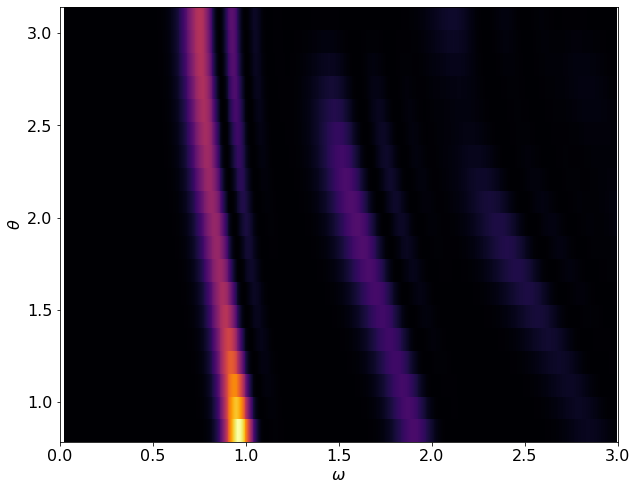

In [13]:
# Integrate over phi and plot spectrum
d_phi = phi_arr[1] - phi_arr[0]
I_theta_w = np.sum(I_phi_theta_w, axis=0)

fig, ax = plt.subplots(figsize=(10,8))
plt.pcolormesh(w, theta_arr, I_theta_w, cmap='inferno')
ax.set_xlim([0,3.])
plt.xlabel('$\omega$')
plt.ylabel('$\\theta$')
plt.show()